In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
from torch.nn.utils.parametrizations import orthogonal

class MonoLinear(nn.Module):
    def __init__(self, in_dim, out_dim, activation=nn.CELU()):
        super().__init__()
        self.in_dim, self.out_dim = in_dim, out_dim
        self.V = orthogonal(nn.Linear(in_dim, in_dim, bias=False))
        self.S = nn.Parameter(torch.randn(max(in_dim, out_dim)))
        self.U = orthogonal(nn.Linear(out_dim, out_dim))

    def forward(self, x):
        x = self.V(x) 
        S = torch.sigmoid(self.S)
        x = x @ torch.diag(S)[:self.in_dim, :self.out_dim]
        x = self.U(x)
        return x

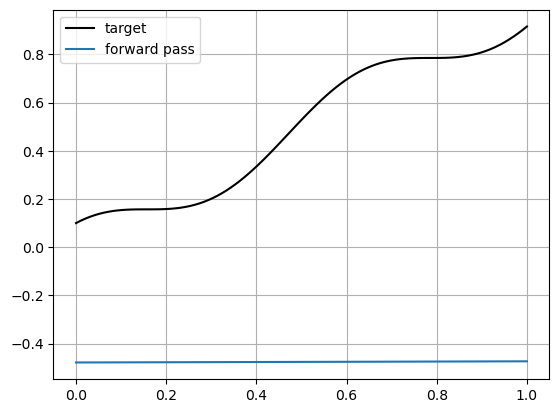

In [3]:
dim = 256
x = torch.linspace(0, 1, 100).unsqueeze(-1)
target = torch.cos(10*x)/10+x
target = target

model = nn.Sequential(
    MonoLinear(1, dim),
    nn.CELU(),
    MonoLinear(dim, dim),
    nn.CELU(),
    MonoLinear(dim, 1),
)

y = model(x).detach()
plt.plot(x, target, "k", label='target')
plt.plot(x, y, label='forward pass')
plt.legend()
plt.grid()
plt.show()

In [4]:
from tqdm.auto import tqdm
opt = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
for i in (pbar:=tqdm(range(10000))):
    loss = ((model(x)- target)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    pbar.set_postfix({'rmse': loss.item()**0.5})
    losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

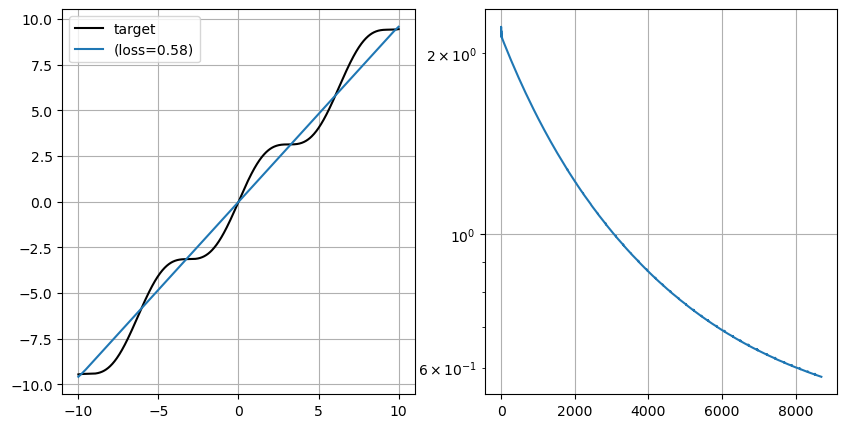

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x, target, "k", label='target')
plt.plot(x, model(x).detach(), label=f'(loss={loss.item()**0.5:.2f})')
plt.grid()
plt.legend()
plt.subplot(122)
plt.semilogy(losses)
plt.grid()
plt.show()